# Beta Bank Churn

# Introduction

I have data on Beta Bank customers, and my goal is to prediect whether not they will leave soon. My data includes contract termination status. To predict their behavior, I will try out a variety of supervised machine learning classifier models - logistic regression, decision tree, random forest. I'll look for duplicate rows and fill in missing values like usual. I'll split the data into feature and target sets. To train the logistic regression model, I will have to one-hot encode the categorical features and standardize the numeric features; for the tree/forest models, I will use ordinal encoding and numeric standardization. I will split both dataframes into training, validation, and test sets.

I will examine the balance of classes in the target, and try building my models without balancing the classes, taking note of the F1 and accuracy scores. When I train my models, I will be optimizing for the highest possible F1 score, with accuracy as a sidenote.

Then I will use downsampling and upsampling functions to balance the numbers of positive and negative target observations (the classes), train and validate the models with these fully preprocessed data sets, and select the model with the highest F1 score. At the end I will test the model's final F1 score using the testing set and find the AUC-ROC score. The primary requirement for a successful model is that the tested F1 score is at least 0.59. I will also do a sanity check on the accuracy and require the final tested model to surpass the accuracy score gleaned from chance, and the AUC-ROC will need to be over 0.50.

Personally, I hope to gain greater understanding of how to preprocess data for different models, and how to balance classes. 

***Note to reviewer: using the enhanced performance package for Intel processors below, runtime was 25 seconds. When I ran the code without it, it took my laptop more than five minutes or so to finish running the code (I lost patience and stopped waiting). If the code doesn't run for you in a timely manner, I have an alternate model you can run that has the same hyperparameters and whatnot as what I found to be ideal. I hope that's OK.***

In [1]:
import timeit
start = timeit.default_timer()

In [36]:
import pandas as pd
import matplotlib.pyplot as plt 

# from sklearnex import patch_sklearn # Enhanced performance package for Intel processors
# patch_sklearn()

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

from joblib import dump

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Preprocessing

In [3]:
try:
    df = pd.read_csv('churn.csv')
except:
    df = pd.read_csv('/datasets/churn.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Almost 10% of the tenure data is missing. I don't want to drop these rows, but I should fill in the nans for the machine learning algorithms. Let's check normality.

<Axes: >

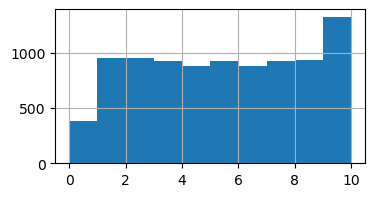

In [5]:
df.Tenure.hist(figsize=(4,2))   

The distribution is uniform, not normal. Though mean and median look like they will be about equal anyway. Let's just use the median to fill in values.

In [6]:
df.Tenure = df.Tenure.fillna(df.Tenure.median()).astype('int')

In [7]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int32  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int32(1), int64(8), object(3)
memory usage: 1.0+ MB


In [9]:
df.duplicated().sum()

0

There are no duplicate rows, and missing values have been filled.

I will process the dataframe using one-hot encoding for when we test our logistic regression model, and separately using ordinal encoding for when we test our decision tree and random forest classifier models. The categorical features, geography and gender, are both nominal, so we won't have to worry about assigning orders to them. Before that I will collect the features and targets into their own DataFrames/Series.

In [10]:
features = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1) # Omit unhelpful features (identifiers) along with the target
target = df.Exited

## Prepare logistic regression data

In [11]:
features_ohe = pd.get_dummies(features, drop_first=True) # Create one-hot encoded dataframe for logistic regression

Now that we've dealt with the categorical variables, I'd like to standardize the numeric variables. We can use the standard scaler class for this. But, we'll need to split up the data into training, validation, and testing sets before I standardize the data, to make sure the class uses the most precise mean/variance for its calculations.

I want 60% of the data to be used for training, and 20% for the validation and test sets each. 
We will first split the features and target datasets into a training set and a test set, at an 80/20 ratio. 
Then, we can further divide this new training set into an ultimate training set and a validation set. In this case, the validation set needs to come from 25% of the training set to give us the 60/20/20 ratio. This is because 25% of 80 equals 20.

In [12]:
x_train, features_test_ohe, y_train, target_test = train_test_split(
    features_ohe, target, test_size=0.2, random_state=123)

features_train_ohe, features_valid_ohe, target_train, target_valid = train_test_split(
    x_train, y_train, test_size=0.25, random_state=123)

In [13]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] # Create mask of numeric features

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [14]:
features_train_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8189,0.652468,-1.698690,1.096509,-1.213083,0.781092,1,0,-0.535390,0,0,1
8845,0.796864,0.002583,-1.450269,0.886952,-0.920634,1,1,1.637287,1,0,0
1165,0.621526,0.947735,0.005033,1.258423,0.781092,0,0,1.681465,1,0,0
1742,-0.698668,1.420312,-1.450269,0.022130,-0.920634,0,0,0.672609,1,0,0
1139,0.776236,1.703857,-1.450269,0.538309,-0.920634,0,1,-1.715362,0,1,0


The table looks as it is supposed to. The nominal categorical features have been split into binary features, and the numeric features have been scaled.

## Prepare decision tree/random forest data

In [15]:
encoder = OrdinalEncoder()
features_ordinal = pd.DataFrame(encoder.fit_transform(features), columns=features.columns) # Create label encoded dataframe for decision trees
features_ordinal.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0


Here I will split up the dataset in the same manner as last time.

In [16]:
x_train, features_test_ord, y_train, target_test = train_test_split(
    features_ordinal, target, test_size=0.2, random_state=123)

features_train_ord, features_valid_ord, target_train, target_valid = train_test_split(
    x_train, y_train, test_size=0.25, random_state=123)

Let's standardize the numeric features. We will again fit the scaler to the training set, and use this scaler to scale the training, validation, and test sets.

In [17]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] # Create mask of numeric features

scaler = StandardScaler()
scaler.fit(features_train_ord[numeric])

features_train_ord[numeric] = scaler.transform(features_train_ord[numeric])
features_valid_ord[numeric] = scaler.transform(features_valid_ord[numeric])
features_test_ord[numeric] = scaler.transform(features_test_ord[numeric])

In [18]:
features_train_ord.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
8189,0.652823,0.0,1.0,-1.700024,1.096509,-0.950460,0.781092,1.0,0.0,-0.539820
8845,0.797391,1.0,0.0,0.002775,-1.450269,1.025270,-0.920634,1.0,1.0,1.629777
1165,0.621844,1.0,0.0,0.948774,0.005033,1.692765,0.781092,0.0,0.0,1.670968
1742,-0.699922,1.0,0.0,1.421774,-1.450269,-0.720451,-0.920634,0.0,0.0,0.681011
1139,0.776739,2.0,0.0,1.705574,-1.450269,0.148889,-0.920634,0.0,1.0,-1.704923


The table looks as it is supposed to. The nominal categorical features have been turned into encoded into numbers, and the numeric features have been standardized.

# Train models without balancing classes

We can look at the target Series to see the balance between positive and negative classes.

In [19]:
target_classes = target.value_counts()
print(target_classes)

0    7963
1    2037
Name: Exited, dtype: int64


In [20]:
class_ratio = target_classes[0]/target_classes.sum() #Perform sanity check
print(class_ratio, 'of the target observations are negative.')

0.7963 of the target observations are negative.


Looks like there are far more negative target observations than positive ones. We'll try to balance this later, but for now we will train some models. This will help us to see the importance of class balance. We will evaluate models based on accuracy (must be at least 80% accurate, per sanity check), and ultimately on highest F1 score.

## Logistic regression model

In [21]:
model = LogisticRegression(solver='liblinear', random_state=123) # Using liblinear for small dataset
model.fit(features_train_ohe, target_train)

pred_train = model.predict(features_train_ohe)
f1_score_train = f1_score(target_train, pred_train)
accuracy_train = accuracy_score(target_train, pred_train)

print('F1 score for training set:', f1_score_train)
print('Accuracy for training set:', accuracy_train)

pred_valid = model.predict(features_valid_ohe)
f1_score_valid = f1_score(target_valid, pred_valid)
accuracy_valid = accuracy_score(target_valid, pred_valid)

print('F1 score for validation set:', f1_score_valid)
print('Accuracy for validation set:', accuracy_valid)

F1 score for training set: 0.30597014925373134
Accuracy for training set: 0.814
F1 score for validation set: 0.2783882783882784
Accuracy for validation set: 0.803


The logistic regression model performed more poorly with regards to its F1 score than I expected. The lower F1 score for the validation set may indicate some overfitting. The accuracy is just above the 0.80 threshold.

## Decision tree model

In [22]:
best_depth = 0
model_accuracy = 0
best_f1_score = 0
model_tree = None

for depth in range(1,11):
    model = DecisionTreeClassifier(max_depth=depth, random_state = 123) # create instance of class
    model.fit(features_train_ord, target_train) # Fit model with training data
    pred_valid = model.predict(features_valid_ord)
    
    f1_score_var = f1_score(target_valid, pred_valid) # Calculate f1 score
    accuracy = accuracy_score(target_valid, pred_valid)

    # Document the highest-performing hyperparamaters, along with their corresponding accuracy
    if f1_score_var > best_f1_score: 
        best_f1_score = f1_score_var
        model_accuracy = accuracy
        best_depth = depth
        model_tree = model
        
print(f'Best F1 score: {best_f1_score} obtained using max depth {best_depth}.') 
print(f'Model accuracy: {model_accuracy}') 

Best F1 score: 0.5393586005830905 obtained using max depth 8.
Model accuracy: 0.842


Using a decision tree, the f1 score is a bit shy of the requirement, but its accuracy is above the requirement. Let's try the random forest.

## Random forest model

In [23]:
best_f1_score = 0
model_accuracy = 0
best_est = 0
best_depth = 0
model_forest = None

for est in range (10, 101, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(
            max_features=1.0, # The lack of this hyperparameter was causing warnings.
            n_estimators=est, max_depth=depth, random_state=123)
        model.fit(features_train_ord, target_train)
        pred_valid = model.predict(features_valid_ord)
        
        f1_score_var = f1_score(target_valid, pred_valid) # Calculate f1 score
        accuracy = accuracy_score(target_valid, pred_valid)
        
        if f1_score_var > best_f1_score: 
            best_f1_score = f1_score_var
            model_accuracy = accuracy
            best_depth = depth
            best_est = est
            model_tree = model
            
print(f"Best F1 score: {best_f1_score} obtained using {best_est} trees with\
 max_depth {best_depth}.")
print(f'Model accuracy: {model_accuracy}')

Best F1 score: 0.5674418604651164 obtained using 60 trees with max_depth 8.
Model accuracy: 0.8605


The random forest model performs a bit better in terms of F1 score than the single decision tree. However it still has not reached the requirement of 0.59. The accuracy is still above the 0.80 cutoff. Let's try logistic regression, using the OHE features.

The model with the top F1 score is currently the random forest classifier with an F1 score of 0.56, which is nearly at our requirement of 0.59. Balancing the classes should be able to improve the F1 score for this model sufficiently. I am also curious to see what improvements, if any, are made to the logistic regression classifier.

# Balance classes and retrain models

Below I will input upsampling and downsampling functions that I can use when I balance the classes.

In [24]:
def upsample(features, target, repeat): # Upsamples the positive class
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321)

    return features_upsampled, target_upsampled

In [25]:
def downsample(features, target, fraction): # Downsamples the negative class
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=54321)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=54321)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=54321)

    return features_downsampled, target_downsampled

## Logistic regression model

Let's balance the classes by both downsampling a bit and by upsampling, first focusing on the logistic regression datasets. My goal for this model is for the classes to be evenly balanced.

In [26]:
features_train_ohe_downsampled, target_train_downsampled = downsample(features_train_ohe, target_train, 0.5)
features_train_ohe_balanced, target_train_balanced = upsample(features_train_ohe_downsampled, target_train_downsampled, 2)

print(features_train_ohe_balanced.shape)
print(target_train_balanced.shape)
print(target_train_balanced.value_counts())

(4804, 11)
(4804,)
1    2406
0    2398
Name: Exited, dtype: int64


The classes have been balanced evenly through a combination of downsampling and upsampling. The two sets have the same length, as expected.

In [27]:
model = LogisticRegression(solver='liblinear', random_state=123) # Using liblinear for small dataset
model.fit(features_train_ohe_balanced, target_train_balanced)

pred_train = model.predict(features_train_ohe)
f1_score_train = f1_score(target_train, pred_train)
accuracy_train = accuracy_score(target_train, pred_train)

print('F1 score for training set:', f1_score_train)
print('Accuracy for training set:', accuracy_train)
print()

pred_valid = model.predict(features_valid_ohe)
f1_score_valid = f1_score(target_valid, pred_valid)
accuracy_valid = accuracy_score(target_valid, pred_valid)

print('F1 score for validation set:', f1_score_valid)
print('Accuracy for validation set:', accuracy_valid)

F1 score for training set: 0.4860253015592822
Accuracy for training set: 0.7088333333333333

F1 score for validation set: 0.49871904355251917
Accuracy for validation set: 0.7065


The validation F1 score is a good bit higher than it was when the classes were unbalanced, though still a good bit below the requirement. The accuracy score also dropped.

## Decision tree model

Now I will balance the datasets with ordinal labels in the same ratio as I did above.

In [28]:
features_train_ord_downsampled, target_train_downsampled = downsample(features_train_ord, target_train, 0.5)
features_train_ord_balanced, target_train_balanced = upsample(features_train_ord_downsampled, target_train_downsampled, 2)

print(features_train_ord_balanced.shape)
print(target_train_balanced.shape)
print(target_train_balanced.value_counts())

(4804, 10)
(4804,)
1    2406
0    2398
Name: Exited, dtype: int64


In [29]:
best_depth = 0
model_accuracy = 0
best_f1_score = 0
model_tree = None

for depth in range(1,11):
    model = DecisionTreeClassifier(max_depth=depth, random_state = 123) # create instance of class
    model.fit(features_train_ord_balanced, target_train_balanced) # Fit model with training data
    pred_valid = model.predict(features_valid_ord)
    
    f1_score_var = f1_score(target_valid, pred_valid) # Calculate f1 score
    accuracy = accuracy_score(target_valid, pred_valid)

    # Document the highest-performing hyperparamaters, along with their corresponding accuracy
    if f1_score_var > best_f1_score: 
        best_f1_score = f1_score_var
        model_accuracy = accuracy
        best_depth = depth
        model_tree = model
        
print(f'Best F1 score: {best_f1_score} obtained using max depth {best_depth}.') 
print(f'Model accuracy: {model_accuracy}') 

Best F1 score: 0.5482456140350878 obtained using max depth 4.
Model accuracy: 0.794


The F1 score is a bit higher than it was before balancing classes, but still has not met the requirement.

## Random forest model

Since the random forest model was the top-performing model in the previous section, I want to do my best to optimize this one. Instead of making the classes equal, I want to add loops into my model training that will upsample and downsample my data at different multipliers and fractions, in addition to looping through the number of estimators and the max depth. To keep the model performing at a reasonable speed, I will keep my number of estimators in a tighter range than I did previously, which hopefully will also help to avoid overfitting.

***Note to reviewer: here is the code block that might cause a jam - comment out this block, and remove the comment markers from the next cell block below if the code takes too long to run.***

In [30]:
best_f1_score = 0
model_accuracy = 0
best_est = 0
best_depth = 0
model_forest = None
best_x = 0
best_y = 0

for x in range(5, 11): # Loop through downsampling fractions 0.5 to 1 (see downsample function call below)
    for y in range(1, 4): # loop through upsample multipliers 1 to 3 (see upsample function call below)
        for est in range (20, 51, 10):
            for depth in range (1, 11):
                
                features_train_ord_downsampled, target_train_downsampled = downsample(features_train_ord, target_train, x/10)
                features_train_ord_balanced, target_train_balanced = upsample(features_train_ord_downsampled, target_train_downsampled, y)
                
                model = RandomForestClassifier(
                    max_features=1.0, # The lack of this hyperparameter was causing warnings.
                    n_estimators=est, max_depth=depth, random_state=123)
                model.fit(features_train_ord_balanced, target_train_balanced)
                pred_valid = model.predict(features_valid_ord)

                f1_score_var = f1_score(target_valid, pred_valid) # Calculate f1 score
                accuracy = accuracy_score(target_valid, pred_valid)

                if f1_score_var > best_f1_score: 
                    best_f1_score = f1_score_var
                    model_accuracy = accuracy
                    best_depth = depth
                    best_est = est
                    model_forest = model  
                    best_x = x
                    best_y = y
            
print(f"Best F1 score: {best_f1_score} obtained using {best_est} trees with\
 max_depth {best_depth}.")
print(f'Ideal class balance achieved using downsampling fraction {x/10} and upsampling multiplier {y}.')
print(f'Model accuracy: {model_accuracy}')

The F1 score measured from the validation set is 0.61, which is above our 0.59 requirement! This score resulted from zero downsampling and 3x upsampling. Perhaps removing training data is not always ideal. 
Hyperparameters: 30 trees, max depth 9.
With zero downsampling and 3x upsampling.

In [31]:
# features_train_ord_downsampled, target_train_downsampled = downsample(features_train_ord, target_train, 1)
# features_train_ord_balanced, target_train_balanced = upsample(features_train_ord_downsampled, target_train_downsampled, 3)

# model_forest = RandomForestClassifier(
#     max_features=1.0, # The lack of this hyperparameter was causing warnings.
#     n_estimators=30, max_depth=9, random_state=123)
# model_forest.fit(features_train_ord_balanced, target_train_balanced)
# pred_valid = model_forest.predict(features_valid_ord)

# f1_score_var = f1_score(target_valid, pred_valid) # Calculate f1 score
# accuracy = accuracy_score(target_valid, pred_valid)
            
# print(f"Best F1 score: {f1_score_var} obtained using 30 trees with\
#  max_depth 9.")
# print(f'Ideal class balance achieved using downsampling fraction 1.0 and upsampling multiplier 3.')
# print(f'Model accuracy: {accuracy}')

Best F1 score: 0.5909090909090909 obtained using 30 trees with max_depth 9.
Ideal class balance achieved using downsampling fraction 1.0 and upsampling multiplier 3.
Model accuracy: 0.82


# Test model

Let's test our highest performing model, the random forest model.

In [32]:
pred_test = model_forest.predict(features_test_ord)
f1_score_test = f1_score(target_test, pred_test)
accuracy_test = accuracy_score(target_test, pred_test)

print('F1 score for test set:', f1_score_test)
print('Accuracy for test set:', accuracy_test)

F1 score for test set: 0.6313416009019166
Accuracy for test set: 0.8365


Perfect, the F1 score is comfortably above our requirement of 0.59! And the accuracy is above our requirement of 0.80 as well, showing that our model performs better than guessing all zeroes. Let's check out the AUC-ROC score. It should at least be 0.5, which is the score that guessing would obtain.

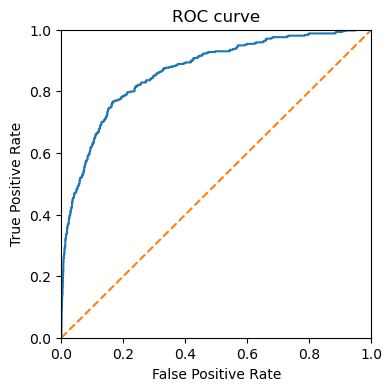

AUC-ROC score: 0.8657912531754299


In [33]:
probabilities_test = model_forest.predict_proba(features_test_ord)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f"AUC-ROC score: {auc_roc}")

The AUC-ROC score is well above 0.5, and the curve looks excellent. This model satisfies all requirements.

In [34]:
# Save the model to a joblib file for sharing
# dump(model_forest, 'BetaBankChurnPredictor.joblib')

# Conclusion

My goal was to build a classification model that could predict whether or not Beta Bank customers would churn in the near future. To accomplish this I processed the data by splitting it into features/targets, splitting those into training/validation/testing sets, and encoding/standardizing the features in ways appropriate to the models that I was training - one-hot encoding for logistic regression, and label encoding for decision tree and random forest. I eventually balanced the classes and found that the random forest model (with 30 trees, a max depth of 9, zero downsampling, and 3x upsampling) performed best in regards to F1 score. The requirement for F1 score was 0.59, and this model had a 0.64 F1 score when trained with the Intel extension for scikit-learn, and a 0.63 F1 score without this extension, along with accuracy and AUC-ROC scores that passed sanity checks. I saved the model as a .joblib file to my machine for safekeeping.

Personally, I enjoyed figuring out when to use one-hot encoding vs label encoding, and thinking about how to standardize my numeric features. Balancing classes was trickier than I expected, but ultimately I was able to refine my F1 score from just barely reaching the requirement to comfortably surpassing it, by using methods that I didn't explicitly learn in the sprint (tweaking the levels of upsampling and downsampling) which I found satisfying. I also have never tested the efficacy of the Intel performance-enhancing package before, and am seriously impressed by both its increased accuracy and speed.

In [35]:
stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  57.575938
